In [227]:
import numpy as np
import pygame
import pandas as pd
import random
from subprocess import Popen, PIPE, STDOUT
import gymnasium as gym
from gymnasium import spaces
import time

class TestEnv(gym.Env):
	#metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 4}

	def __init__(self, render_mode=None ):
		#self.size = size  # The size of the square grid
		
		self.number_to_state = {'0' : '?', '1':'blocked' , '2':'hidden'}
		self.state_to_number = {'?' : '0', 'blocked':'1' , 'hidden':'2'}
		#self._nb_features = 39
		self.characters = [ 'char1', 'char2','char3','char4']
		self.acting_character = self.characters[0]
		self.additional_utility = None
		self.df_effects = pd.read_csv('..\data\effects_nn.csv')

		
		self.randomize_df()
		
		self.create_file(self.characters,self.df.loc[0])
		self._nb_features = len(self.df.columns)
		# Observations are dictionaries with the agent's and the target's location.
		# Each location is encoded as an element of {0, ..., `size`}^2, i.e. MultiDiscrete([size, size]).
		self.observation_space = spaces.Box(
			-3,
			3,
			shape = [0,self._nb_features]
		)

		self.target_feature = 'ship_status'
		self.target_value = '-1'

		# We have 4 actions, corresponding to choosing character
		self.action_space = spaces.Discrete(10)

		"""
		The following dictionary maps abstract actions from `self.action_space` to
		the direction we will walk in if that action is taken.
		
		"""
		self._action_to_direction = {
			0: 'char1',
			1: 'char2',
			2: 'char3',
			3: 'char4',
			4: 'ship_status(world) > 0',
			5: 'ship_magic(world) > 0',
			6: 'ship_defense(world) > 0',
			7: 'ship_status(world) < 0',
			8: 'ship_magic(world) < 0',
			9: 'ship_defense(world) < 0',
		}

		

		



	def randomize_df(self):
		

		lists = []
		columns = []
		for c in self.characters:
			columns.append(c+"_health")
			lists.append([i for i in range(0,3)])

			columns.append(c+"_knowledge")
			lists.append([i for i in range(0,3)])

		

			columns.append(c+"_altruism")
			lists.append([i for i in range(-2,3)])
			columns.append(c+"_ambition")
			lists.append([i for i in range(0,5)])
			
			columns.append(c+"_support")
			lists.append([i for i in range(0,2)])

			columns.append(c+"_money")
			lists.append([i for i in range(0,2)])
			
			columns.append(c+"_satisfaction")
			lists.append([0])

			columns.append(c+"_state")
			#lists.append(['?','blocked','hidden'])
			lists.append(['0','1','2'])

			char_without_c = self.characters.copy()
			char_without_c.remove(c)
			for c2 in char_without_c:
				columns.append(c+"_relation_"+c2)
				lists.append([i for i in range(-2,3)])
				columns.append(c+"_supports_"+c2)
				lists.append([0,1])

			


		columns.append("ship_defense")
		lists.append([-1,0,1])

		columns.append("ship_status")
		lists.append([-1,0,1])

		columns.append("ship_magic")
		lists.append([-1,0,1])
		self.df = pd.DataFrame( columns=columns )

		d = []
		for l in lists:
			d.append(random.choice(l))
		self.df.loc[len(self.df)] = d
		
		
	def create_file(self,characters,row):
		with open("../lib/rl_planner.txt", 'w') as f:
			f.write("""//### Types:
type item;
type world;
type state;

//### Properties:
property health(char: character) : number; 
property knowledge(char: character) : number; 
property authority(char: character) : number; 


property satisfaction(char: character) : number; // Satisfaction level of each character
property altruism(char: character) : number; // Altruism level of each character (-3 to 3)
property ambition(char: character) : number; // Ambition level of each character (-3 to 3)
property max_ambition(char: character) : number; // Ambition level of each character (-3 to 3)
property relation(char: character, other: character) : number; // Relationship liking level between characters (-3 to 3)
property support(char: character) : number; 
property supports(char: character, other: character) : boolean;
property money(char: character) : number; 
property state(char: character) : state; 

property ship_defense(world:world) : number; 
property ship_magic(world:world) : number; 
property ship_status(world:world) : number;

property later(world:world) : boolean; 
entity world:world;

entity hidden :state;
entity blocked :state;
		   """
			)
			

				#warrtosci postaci
			for char in self.characters:
			
				f.write("entity "+ char + ": character;  \n")
				f.write("health(" + char  +") = " + str(row[char+"_health"]) + " ;\n")
				f.write("altruism(" + char  +") = " + str(row[char+"_altruism"]) + " ;\n")
				f.write("ambition(" + char  +") = " + str(row[char+"_ambition"]) + " ;\n")
				f.write("knowledge(" + char  +") = " + str(row[char+"_knowledge"]) + " ;\n")
				f.write("support(" + char  +") = " + str(row[char+"_support"]) + " ;\n")
				f.write("money(" + char  +") = " + str(row[char+"_money"]) + " ;\n")

				
				
				f.write("state(" + char  +") = " + self.number_to_state[row[char+"_state"]]  + " ;\n")
				
				char_without_c = characters.copy()
				char_without_c.remove(char)
				for c2 in char_without_c:
					f.write("relation(" + char  +", "+ c2 +") = " + str(row[char+"_relation_"+c2]) + " ;\n")
					if str(row[char+"_relation_"+c2]) == 1:
						f.write("supports(" + char  +", "+ c2 +")   ;\n")
				   
				f.write("ship_defense(world) =" +str(row['ship_defense']) + ";  \n")
				f.write("ship_status(world) =" +str(row['ship_status']) + " ; \n")
				f.write("ship_magic(world) =" +str(row['ship_magic']) + ";  \n")
			

				
				

			f.write("""//key akcje
	action key_action1(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&ship_defense(world) > 0
			&ship_status(world) < 0
			;
		effect:
			if(altruism(char) > 2 & ambition(char) > 2 )
				satisfaction(char) = satisfaction(char) + 1
			;
		consenting: char;
	}};


	action key_action2(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			//&ship_status(world) < 0
			&authority(char) > 1
			&relation(char2,char1) < 0
			;
		effect:
			if(altruism(char) <= 2 & ambition(char) > 2 )
				satisfaction(char) = satisfaction(char) + 1
			
			;
		consenting: char;
	}};

	action key_action3(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&ship_magic(world) > 0
			&ship_status(world) > 0
			;
		effect:
			if(ambition(char) <= 2 )
			 satisfaction(char) = satisfaction(char) + 1
			;
		consenting: char;
	}};


//akcje

	action change_health_down(char:character,char2:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			health(char2) = health(char2) - 1
			& later(world) 
			;
		consenting: char;
	}};

	action change_health_up(char:character,char2:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			health(char2) = health(char2) + 1 
			& later(world)
			;
		consenting: char;
	}};


	 action change_knowledge_down(char:character,char2:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&knowledge(char) > 1
			&char == {0}
			;
		effect:
			knowledge(char2) = knowledge(char2) - 1
			& later(world) 
			;
		consenting: char;
	}};

	action change_knowledge_up(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			&state(char) == hidden
			;
		effect:
			knowledge(char) = knowledge(char) + 1
			& later(world)
			;
		consenting: char;
	}};

	action change_relation_down(char:character,char2:character,char3:character) {{
		precondition:
	
			health(char) > 0
			&state(char)!= blocked 
			&char == {0}
			;
		effect:
			relation(char2,char3) = relation(char2,char3) - 1 
			& health(char) = health(char) - 1 
			& later(world)
			;
		consenting: char;
	}};

	action change_relation_up(char:character,char2:character,char3:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			relation(char2,char3) = relation(char2,char3) + 1 
			& later(world)
			;
		consenting: char;
	}};


	action hide(char:character) {{
		precondition:
	
			health(char) > 0 
			& state(char) != hidden
			&state(char)!= blocked
			;
		effect:
			state(char) = hidden
			& later(world)
			;
		consenting: char;
	}};

	action find(char:character,char2:character) {{
		precondition:
	
			health(char) > 0 
			& state(char2) == hidden
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			state(char2) = ?
			& later(world)
			;
		consenting: char;
	}};

	action block(char:character,char2:character) {{
		precondition:
	
			 state(char2) != blocked
			 &char == {0}
			;
		effect:
			state(char2) = blocked
			& later(world)
			;
		consenting: char;
	}};

	action unblock(char:character,char2:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			& state(char2) == blocked
			&char == {0}
			;
		effect:
			state(char2) = ?
			& later(world)
			;
		consenting: char;
	}};
		   
		   action unblock_yourself(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)== blocked
			
			&char == {0}
			;
		effect:
			state(char) = ?
			& later(world)
			;
		consenting: char;
	}};

	action change_ship_defense_down(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			ship_defense(world) = ship_defense(world) - 1
			& later(world)
			;
		consenting: char;
	}};

	action change_ship_defense_up(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			ship_defense(world) = ship_defense(world) + 1
			& later(world)
			
			;
		consenting: char;
	}};


	action change_ship_magic_down(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			ship_magic(world) = ship_magic(world) - 1
			& later(world)
			;
		consenting: char;
	}};

	action change_ship_magic_up(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			ship_magic(world) = ship_magic(world) + 1
			& later(world)
			;
		consenting: char;
	}};


	action change_ship_status_down(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
		   &char == {0}
			;
		effect:
			ship_status(world) = ship_status(world) - 1
			& later(world)
			;
		consenting: char;
	}};

	action change_ship_status_up(char:character) {{
		precondition:
	
			health(char) > 0 
			&state(char)!= blocked
			&char == {0}
			;
		effect:
			ship_status(world) = ship_status(world) + 1
			;
		consenting: char;
	}};


	action support(char:character,char2:character, char3:character) {{
		precondition:
	
			 state(char) != blocked
			 &char == {0}
			 &char != char2
			 &!supports(char,char2)
			;
		effect:
			supports(char,char2)
			& support(char2) = support(char2) + 1
			& later(world)
			;
		consenting: char;
	}};

action lose_support(char:character,char2:character) {{
		precondition:
	
			 state(char) != blocked
			 &char == {0}
			 &char != char2
			 &supports(char,char2)
			;
		effect:
			!supports(char,char2)
			& support(char2) = support(char2) - 1
			& later(world)
			;
		consenting: char;
	}};

action support_money(char:character,char2:character, char3:character) {{
		precondition:
	
			 state(char) != blocked
			 &char != char3
			 &char != char2
			 &char == {0}
			 &!supports(char2,char3)
			 &money(char) > 0
			;
		effect:
			supports(char2,char3)
			& support(char3) = support(char3) + 1
			& later(world)
			&money(char) = money(char) - 1
			&money(char2) = money(char2) + 1
			;
		consenting: char;
	}};

action lose_support_money(char:character,char2:character, char3:character) {{
		precondition:
	
			 state(char2) != blocked
			 &char == {0}
			 &char != char3
			 &char != char2
			 &supports(char2,char3)
			  &money(char) > 0
			;
		effect:
			!supports(char2,char3)
			& support(char3) = support(char3) - 1
			& later(world)
			&money(char) = money(char) - 1
			&money(char2) = money(char2) + 1
			;
		consenting: char;
	}};

action support_authority(char:character,char2:character, char3:character) {{
		precondition:
	
			 state(char2) != blocked
			 &char != char3
			 &char != char2
			 &char == {0}
			 &!supports(char2,char3)
			 &authority(char) > 2
			;
		effect:
			supports(char2,char3)
			& support(char3) = support(char3) + 1
			& later(world)
		   
			;
		consenting: char;
	}};

action lose_support_authority(char:character,char2:character, char3:character) {{
		precondition:
	
			 state(char2) != blocked
			 &char == {0}
			 &char != char3
			 &char != char2
			 &supports(char2,char3)
			 &authority(char) > 2
			;
		effect:
			!supports(char2,char3)
			& support(char3) = support(char3) - 1
			& later(world)
			
			;
		consenting: char;
	}};


trigger authority_calc(char:character) {{
	precondition:
		authority(char) != (if (health(char)>2)  1 else 0 )+  knowledge(char) + support(char)  ;
	effect:
		authority(char) == (if (health(char)>2)  1 else 0 ) +  knowledge(char)   + support(char)   ;
}};


			""".format(self.acting_character))

			
			
			f.write("utility(): \n ")
			if self.additional_utility != None:
				f.write("satisfaction({0}) > 0 & {1};\n".format(self.acting_character,self.additional_utility))
			else:
				f.write("satisfaction({0}) > 0;\n".format(self.acting_character))
			
		


			for char in characters:
				f.write("utility({0}): \n ".format(char))
				if (char == self.acting_character) and (self.additional_utility != None):
					f.write("satisfaction({0}) > 0 & {1};\n".format(self.acting_character,self.additional_utility))
				else:
					
					f.write("satisfaction({0}) > 0 ; \n ".format(char))
			
			
			f.close()


	def _get_obs(self):
		df2 = self.df.loc[0]
		
		return df2.to_numpy(dtype='float32')
	
	def _get_info(self):
		return {0:'test'}

	def reset(self, seed=None, options=None):
		# We need the following line to seed self.np_random
		super().reset(seed=seed)

		#randomize row
		self.randomize_df()
		

		observation = self._get_obs() #turn row into observation
		info = self._get_info() #turn row into info

		if self.render_mode == "human":
			self._render_frame()

		return observation, info
	

	
	
	def load_action(self,file):

		
		p = Popen(['java', '-jar', '..\lib\sabre.jar', '-p', file,'-el',"0","-h","h+",'-c','n',"-tl","5000"], stdout=PIPE, stderr=STDOUT)
		#p = Popen(['java', '-jar', 'lib\sabre.jar', '-p', file,'-el',"0",'-g',"","-tl","1000"], stdout=PIPE, stderr=STDOUT)

		lines=[]
		for line in p.stdout:
			lines.append(str(line, encoding='utf-8'))

		#print(lines)
		return lines[0].replace("\r\n","")

	def do_action(self,args):
		if len(args) > 0 and len(self.df_effects[self.df_effects.action == args[0] ]['effect_function'].values) > 0:
			functions = self.df_effects[self.df_effects.action == args[0] ]['effect_function'].values[0].split(';')
			for function in functions:
				parts = function.split(':')

				#choosing feature
				feature = parts[0]
				for count,arg in enumerate(args,0):
					feature = feature.replace('arg'+str(count),arg)

				#choosing how feature is changed
				change = parts[1].split("_")

				print(feature)
				print(change)

				if 'health' in feature:
					return
				
				if change[0] == "=":
					self.df[feature] = change[1]
				elif change[0] == "+":
					self.df[feature] = int(self.df[feature].values[0]) + int(change[1])
				elif change[0] == "-":
					self.df[feature] = int(self.df[feature]) - int(change[1])
				
				if 'state' in feature:
					
					
					self.df.replace(self.state_to_number,inplace=True)  
					
			

	def change_state(self,actions):
		
		
		
		
		if 'No solution' not in actions:
			actions = actions.split(') ')
			
			if len(actions) > 0:
				args = actions[0].replace("("," ").replace(")","").replace(",","")
				print(args)
				if ('key_action' not in args) :
					self.do_action(args.split(" "))
				
				return True
		
		return False

	def make_action(self,action):
		if 'char' in action:
			self.acting_character = action
		else:
			self.additional_utility = action

		self.create_file(self.characters,self.df.loc[0])
		start = time.time()

		
		file = '../lib/rl_planner.txt'
		self.results = self.load_action(file)
		

		end = time.time()
		
		index = 0
		#self.df.loc[index,['results']] = self.results
		#self.df.loc[index,['time']] = (end-start)

		print(self.results)
		self.change_state(self.results)
		
	def get_reward(self):
		#stworzenie targetu na poczatku
		reward = 0
		#czy osiagnelismy target jesli tak to 1
		if self.df.at[0,self.target_feature] == self.target_value:
			reward = 1
		elif 'No solution' in self.results or 'exceeded' in self.results:
			reward = -1
		#jesli nie to 0
		#jesli nie działa to minus
		#jesli to działa, to ustawienie samemu targetu, też w tabeli
		
		return reward

	def step(self, action):
		# Map the action (element of {0,1,2,3}) to the direction we walk in
		direction = self._action_to_direction[action]
		
		self.make_action(direction)

		
		terminated = False
		reward = self.get_reward()
		if reward == 1:
			terminated = True

		observation = self._get_obs()
		info = self._get_info()

		#if self.render_mode == "human":
			

		return observation, reward, terminated, False, info

	def render(self):
		print(self.df.loc[0])

In [228]:
import gymnasium as gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from gymnasium.wrappers import TimeLimit
#env = gym.make("CartPole-v1")
env = TestEnv()
env = TimeLimit(env, max_episode_steps=60)
# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()
# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)

In [81]:
from stable_baselines3.common.env_checker import check_env
check_env(env)

C:\Users\kacpe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\stable_baselines3\common\env_checker.py:263: UserWarning: Your observation  has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  warnings.warn(


Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]". (at line 32, character 25)
Error: Unexpected "]".  at line 32 character 25
Error: Unexpected "]

In [185]:
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))


class ReplayMemory(object):

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [186]:
class DQN(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 59)
        self.layer2 = nn.Linear(59, 59)
        self.layer3 = nn.Linear(59, n_actions)

    # Called with either one element to determine next action, or a batch
    # during optimization. Returns tensor([[left0exp,right0exp]...]).
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [187]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 1000
TAU = 0.005
LR = 1e-4

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done = 0


def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated
    if is_ipython:
        if not show_result:
            display.display(plt.gcf())
            display.clear_output(wait=True)
        else:
            display.display(plt.gcf())

In [188]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

Complete


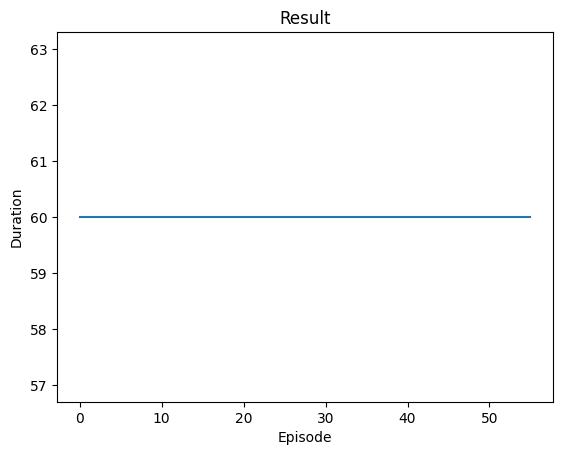

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [229]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
else:
    num_episodes = 50

for i_episode in range(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()